In [1]:
%matplotlib inline

# Word Clustering

In this notebook we will evaluate different word representation using clustering techniques. We will compare a standard representation for the task of Argument Mining developed by (Stab and Gurevych, 2016) with several unsupervised representation using the algorithms word2vec (Mikolov et al, 2013) and glove (Pennington et al, 2014).

## Dataset

We will be analyzing a dataset of text of the European Court of Human Rights (ECHR). We have downloaded all english documents available in their website https://hudoc.echr.coe.int, using this [web scrapper](https://github.com/MIREL-UNC/echr_dataset).


### Preprocess

There are some common preprocessing steps all the word representation require. We apply a first preprocessing step where we create, from the raw text, a intermidiate representation of each document called [UnlabeledDocument](https://github.com/mit0110/argument_mining/blob/master/preprocess/annotated_documents.py#L10).

To build the `UnlabeledDocument` we apply the following steps:
  1. Split paragraphs by new line characters
  2. Divide the paragraphs in sentences with nltk sent_tokenizer
  3. For each sentence:
      3. Tokenize it using nltk word_tokenize
      4. Apply the stanford `LexicalizedStanfordParser` to it and store the resulting tree.
      5. Obtain the PoS tag sequence
  6. Store the result

To build the coocurrence matrix, we use two criteria for reducing the dimensionality:
  * Lemmatization of words.
  * Filtering out words that occur less than 3 times in the entire dataset.

## Word representation

### Coocurrence matrix

To represent each of our instances, i.e. words, the simplest solution is to use the other words in a window context of fixed size. The resulting word vector is a count of the words that appear, for example, within two places to the left or to the right of the target word. This representation is called word co-ocurrence matrix.

Next, we read all our documents and create a coocurrence matrix.

In [63]:
import numpy
import os
import pandas
import random
import seaborn
import sys
sys.path.insert(0, os.path.abspath('..'))
import utils
import coocurrence_matrix

from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering

In [3]:
filename = '/home/mteruel/am/data/echr/scraps/unlabeled_documents_no_trees.sample.p'

documents = utils.pickle_from_file(filename)

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer

word_indices, indices_to_word = coocurrence_matrix.get_word_index(documents, min_frequency=3)
comatrix = coocurrence_matrix.word_coocurrence_matrix(documents=documents,
                                                      indices=word_indices, window_size=5)
transformer = TfidfTransformer()
comatrix = transformer.fit_transform(comatrix)

Using the unlabeled documents we get a total number of words of:

In [5]:
len(indices_to_word)

25291

## Exploration

One way of characterizing a word using the coocurrence matrix is simply sampling the words in the its context. The next function returns an (sorted or not by its number of occurences) list of words in the contex to a given `word`.

In [9]:
def get_words_in_context(word, limit=10, sorted=False):
    if not word in word_indices:
        return []
    word_id = word_indices[word]
    if not sorted:
        context = comatrix[word_id,:].nonzero()[1][:limit]  # Row of words in context
    else:
        context = reversed(numpy.argsort(comatrix[word_id].todense())[0,-limit:].tolist()[0])
    return pandas.DataFrame(
        [(indices_to_word[index], '{0:.3f}'.format(comatrix[word_id,index]))
         for index in context], columns=['Lemma', 'TfiDf']
        )

In [10]:
get_words_in_context('Court', limit=10, sorted=False)

,Lemma,TfiDf
0,secure-n,0.000
1,CPT-n,0.000
2,UK-n,0.000
3,120-n,0.002
4,ensuing-a,0.000
5,daily-r,0.000
6,late-r,0.000
7,Nizami-n,0.000
8,purely-a,0.000
9,97-n,0.003


In [11]:
get_words_in_context('Court', limit=10, sorted=True)

,Lemma,TfiDf
0,the-n,0.667
1,that-n,0.327
2,.-n,0.304
3,The-n,0.252
4,",-n",0.222
5,of-n,0.191
6,note-v,0.141
7,considers-n,0.116
8,to-n,0.106
9,find-v,0.100


However, this representation is not so useful because we are interested in the words relevant to our target word, not common in all documents.

### Closest Words

Using the coocurrence matrix, we can obtain the closest lemmas to a target word using only the euclidean distance. This would be a better way of characterizing a word.

DISCLAIMER: the cosine distance would have been a better option for NLP, but the library does not implement it.

In [ ]:
word_tree = coocurrence_matrix.wordKDTree(comatrix.todense())

def get_closest_words(word, sample_size=10):
    if word not in word_indices:
        return []
    word_vector = comatrix[word_indices[word],:]
    indices = word_tree.get_closest(word_vector.todense(), sample_size)
    return [indices_to_word[index] for index in indices]

In [254]:
', '.join(get_closest_words('Spain'))

'Spain-n, Turkey-n, Italy-n, Poland-n, Romania-n, Georgia-n, Russia-n, Ruiz-n, GC-n, United-n'

In [255]:
', '.join(get_closest_words('April'))

'April-n, March-n, December-n, January-n, November-n, July-n, June-n, 26-n, February-n, 14-n'

### Visualization

We can also visualize the words into a two dimensional space, given that we reduce the dimensionality first. We use the TruncatedSVD algorithm, a standard dimensionality reduction technique that handles very well sparse matrixes. The plot shows the reduced vectors for each lemma, colored by the pos tag in which the lemma was used.

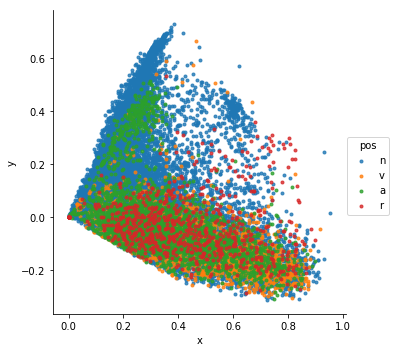

In [13]:
svd_reduced_data = pandas.DataFrame(
    TruncatedSVD(n_components=2).fit_transform(comatrix), columns=['x', 'y'])
svd_reduced_data['pos'] = [indices_to_word[index].split('-')[-1] for index in range(len(svd_reduced_data))]

seaborn.lmplot(x='x', y='y', data=svd_reduced_data, fit_reg=False, hue='pos', markers='.')

TSNE (van der Maaten and Hinton, 2009) is another dimensionality reduction algorithm specially designed for NLP. We show the same visualization in the next graphic, but using TSNE instead of SVD.

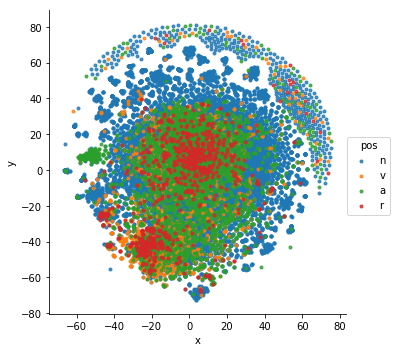

In [17]:
tsne_reduced_data = pandas.DataFrame(
    TSNE(n_components=2, metric='euclidean').fit_transform(comatrix.todense()), columns=['x', 'y'])
tsne_reduced_data['pos'] = [indices_to_word[index].split('-')[-1] for index in range(len(tsne_reduced_data))]

seaborn.lmplot(x='x', y='y', data=tsne_reduced_data, fit_reg=False, hue='pos', markers='.')

## Clustering

First we will try with the kmeans implementation from sklearn. The documentation states that *The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares.*

In [6]:
mbk = KMeans(init='k-means++', n_clusters=10, precompute_distances=True)
kmeans_clusters = mbk.fit_predict(comatrix)

This algorithm has a explicit representation for the geometrical center of each cluster. We can use the centers to calculate the cluster centroid, i.e. the word that is closer to the cluster center.

In [71]:
def get_centroids(estimator, matrix, indices_to_word):
    distances_to_clusters = estimator.transform(matrix)
    closest = numpy.argmin(distances_to_clusters, axis=0)
    centroids = [indices_to_word[lemma_id] for lemma_id in closest]
    return centroids

In [23]:
get_centroids(mbk, comatrix, indices_to_word)

['broken-r',
 'broken-r',
 '64541/01-n',
 '53-n',
 'broken-r',
 'broken-r',
 'to-n',
 'broken-r',
 '02/05/2016-n',
 '63-64-a']

It is still not clear why several clusters have the same centroid, but the phonemenon happened with multiple inicializations and cluster sizes.

### How many clusters?

For the previous example, we used 10 clusters as an example. However, choosing the right number of clusters is not trivial and it depends on the task. The *Calinski Harabaz Score* (Calinski and Harabaz, 1974) is a metric to measure the *ratio between the within-cluster dispersion and the between-cluster dispersion*, and can help us find a more adecuate number of cluster. The higher the value, the "better" is the solution.

In [82]:
from sklearn.metrics import calinski_harabaz_score

def evaluate_clusters(matrix, cluster_k=[5,10,20,50,100]):
    results = pandas.DataFrame(0, index=cluster_k, columns=['Calinski Harabaz Score'])
    for k in cluster_k:
        clusterer = KMeans(init='k-means++', n_clusters=k, precompute_distances=True)
        clusterer.fit(matrix)
        results.loc[k]['Calinski Harabaz Score'] = calinski_harabaz_score(matrix.todense(), clusterer.labels_)
        print(results.loc[k]['Calinski Harabaz Score'])
    return results

In [14]:
evaluate_clusters(comatrix)

611
347
209
108
65


,Calinski Harabaz Score
5,611
10,347
20,209
50,108
100,65


Even if the smaller number of clusters is better, we choose to continue with 10 as it fits better the representation of words we want.

We also train the spectral clustering algorithm from sklearn. *SpectralClustering does a low-dimension embedding of the affinity matrix between samples, followed by a KMeans in the low dimensional space.*

In [25]:
spectral= SpectralClustering(n_clusters=10)
spectral_clusters = spectral.fit_predict(comatrix)

/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/sklearn/cluster/spectral.py:439: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


### Visual comparison

To compare both algoritms we can visualize the clusters with the two dimensionality reduction techniques used before.

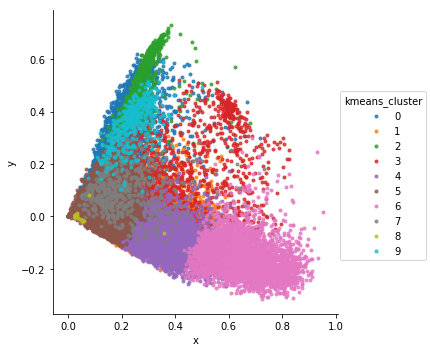

In [20]:
svd_reduced_data['kmeans_cluster'] = kmeans_clusters
seaborn.lmplot(x='x', y='y', data=svd_reduced_data, fit_reg=False, hue='kmeans_cluster', markers='.')

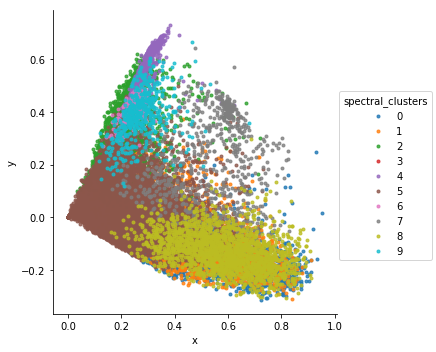

In [26]:
svd_reduced_data['spectral_clusters'] = spectral_clusters
seaborn.lmplot(x='x', y='y', data=svd_reduced_data, fit_reg=False, hue='spectral_clusters', markers='.')

We can see that TruncatedSVD reveals a very similar structure of clustering, although in a different order. **The fact that both algoritms find the same underliyng structure indicates the dimensionality reduction performed by the Spectral clustering algorithm does not generate a more rich representation.**

A similar conclusion can be achieved using the TSNE visualization.

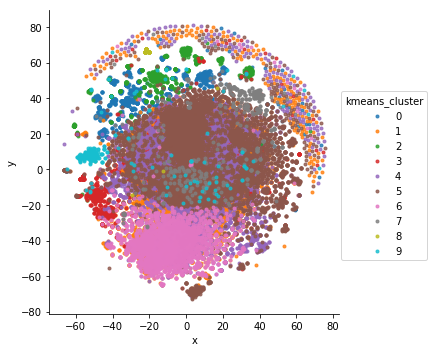

In [21]:
tsne_reduced_data['kmeans_cluster'] = kmeans_clusters
seaborn.lmplot(x='x', y='y', data=tsne_reduced_data, fit_reg=False, hue='kmeans_cluster', markers='.')

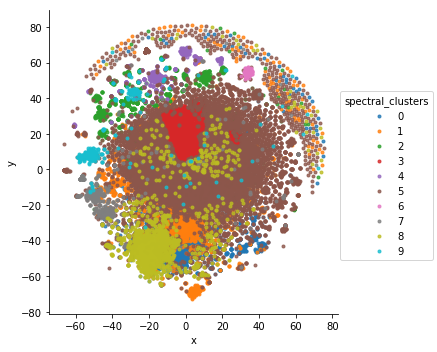

In [27]:
tsne_reduced_data['spectral_clusters'] = spectral_clusters
seaborn.lmplot(x='x', y='y', data=tsne_reduced_data, fit_reg=False, hue='spectral_clusters', markers='.')

### Cluster sampling

To analyze the clusters in detail we take a random sample of words from each cluster. In the tables below we find the results for the KMeans and the Spectral clusters:

In [24]:
def sample_clusters(predictions, num_clusters=10, sample_size=15):
    result = pandas.DataFrame(index=range(sample_size))
    for cluster_index in range(num_clusters):
        word_indices = numpy.where(predictions == cluster_index)[0][:sample_size]
        result['Cluster-{}'.format(cluster_index)] = [indices_to_word[i] for i in word_indices]
    return result
sample_clusters(kmeans_clusters)

,Cluster-0,Cluster-1,Cluster-2,Cluster-3,Cluster-4,Cluster-5,Cluster-6,Cluster-7,Cluster-8,Cluster-9
0,Sciacca-n,behave-v,2003-IX-n,database-n,76a-n,broken-r,reflect-v,Iliev-n,03/06/2015-n,71-74-a
1,Luxembourg-n,admittedly-r,28328/03-n,412-n,Kentron-n,“Anyone-n,national-a,Tomas-n,06/07/2015-n,63-65-a
2,Geyseghem-n,shift-n,22688/09-n,disagree-v,unavoidable-a,Rechtsschutz-n,indication-n,Timerlan-n,STRASBOURG-n,135-136-a
3,Velcea-n,foundational-a,30628/02-n,During-n,depositor-n,2943/3-n,adjustment-n,Răchită-n,17/08/2016-n,149-151-n
4,Ermakov-n,sensibly-r,59548/00-n,S.V.’s-n,Conference-n,Vincent-n,whose-n,Mamazhonov-n,17/02/2016-n,88-89-n
5,Iulian-a,electricity-n,59532/00-n,2943/6-n,Treaties-n,manure-n,adjourn-v,Hefzullah-n,13/01/2016-n,79-81-n
6,Decheva-n,vice-minister-n,33348/96-n,117-n,prosecutor.”-n,panic-a,tell-v,Zirulia-n,FINAL-n,51-52-a
7,Heinisch-n,handler-n,29660/03-n,That-n,circumstantial-a,secret-v,notion-n,Câmpeanu’s-n,20/04/2015-n,113-14-n
8,Rizvanov-n,irritability-n,10593/08-n,г-n,Reduction-n,wish-n,week-n,M.-n,27/01/2016-n,34-38-a
9,Kranczkowski-n,contemporary-a,20364/05-n,143-n,expression-n,sole-n,serve-v,Khasan-n,22/06/2016-n,79-80-n


The KMeans algorithm groups together:

 * Dates in cluester 8
 * Compound numbers of pages or sections in cluster 9, while simple numbers are more present in cluster 3. Cluster 2 is also composed of references to cases.
 * Countries, cities and proper nouns are grouped in cluster 0 and cluster 7

In [29]:
sample_clusters(spectral_clusters)

,Cluster-0,Cluster-1,Cluster-2,Cluster-3,Cluster-4,Cluster-5,Cluster-6,Cluster-7,Cluster-8,Cluster-9
0,Kentron-n,76a-n,Luxembourg-n,broken-r,28328/03-n,unavoidable-a,2003-IX-n,disagree-v,behave-v,71-74-a
1,reflect-v,412-n,Geyseghem-n,panic-a,22688/09-n,“Anyone-n,extract-v,During-n,national-a,Sciacca-n
2,depositor-n,vice-minister-n,Ermakov-n,secret-v,30628/02-n,database-n,1999-VII-n,117-n,indication-n,Rizvanov-n
3,adjourn-v,Treaties-n,Iulian-a,wish-n,59548/00-n,admittedly-r,2002‑IV-n,That-n,shift-n,63-65-a
4,advance-v,prosecutor.”-n,Decheva-n,sole-n,59532/00-n,Rechtsschutz-n,2000‑IX-n,143-n,adjustment-n,Mladenović-n
5,Study-n,notion-n,Heinisch-n,dismissed-a,33348/96-n,Iliev-n,2002‑III-n,317-n,whose-n,135-136-a
6,divorce-v,Reduction-n,Kuznetsov-n,Lithuanian-a,10593/08-n,2943/3-n,2006-III-n,On-n,tell-v,149-151-n
7,recount-v,expression-n,Ay-n,close-r,20364/05-n,foundational-a,2004-VIII-n,144-n,serve-v,Hadri-Vionnet-n
8,region-n,dynamic-n,Albakova-n,proper-v,17116/04-n,Vincent-n,2006-X-n,A.N-n,promote-v,88-89-n
9,Biblical-n,contemporary-a,Shekhov-n,accused’s-n,38565/97-n,manure-n,2000‑VI-n,Only-r,attentive-a,Murray-n


On the other hand, the Spectral algorithm groups together:

 * Dates in cluster 6
 * References and numbers in cluster 9
 * Proper nouns in cluster 2, and mixed with numbers in cluster 5

## Handcrafted features

In this section we will compare the performance of the bag-of-words features against a representation based on handcrafted features. These features were optimized for the task of Argument Mining by (Stab and Gurevych, 2016). The features are:
  * Syntactic features:
      * like the POS tag and token of current, next and previous words.
  * Lexical features like the length of the path to the LCA with the following and preceding token in the parse tree.
  * Structural features:
      * if the word is in the first of last paragraph of the document, and if it is the first or last word in the sentence.
      * the paragraph and sentence number where the word occurs.
      * the position of the word in the sentence, the paragraph and the document.
      * if the word preceeds, is or follows a punctuation mark or a full stop.
      * if the word follows or preceeds a comma or a semicolon.

In [3]:
handcrafted_features = utils.pickle_from_file('/home/mteruel/am/data/echr/unlabeled_matrix.pickle')

In [4]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
vectorizer.fit([word_dict for document_list in handcrafted_features for word_dict in document_list])

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)

The matrix from the preprocess file is a representation for each word occurence in a corpus. We want to create a vector representation for each unique token, so we will combine all the feature dictionaries.

In [5]:
combined_features = defaultdict(list)
from tqdm import tqdm
for document in tqdm(handcrafted_features):
    for feature_dict in document:
        token = feature_dict['ls:token']
        pos = feature_dict['ls:pos_tag']
        combined_features[token + '-' + pos].append(feature_dict)

100%|██████████| 101210/101210 [00:02<00:00, 43830.65it/s]


In [28]:
from scipy.sparse import csr_matrix, vstack
result = []
words = []
for word, feature_dicts in tqdm(combined_features.items()):
    if len(feature_dicts) < 5:
        continue
    result.append(csr_matrix(vectorizer.transform(feature_dicts).sum(axis=0)))
    words.append(word)
result = vstack(result)

100%|██████████| 41822/41822 [01:19<00:00, 525.39it/s] 


Using this handcrafted representation and filtering out words that occur less than 5 times, we obtain a matrix with 12213 words and 180827 features.

In [38]:
result.data = numpy.nan_to_num(result.data, 0)

In [44]:
svd_reduced_data = pandas.DataFrame(
    TruncatedSVD(n_components=2).fit_transform(result), columns=['x', 'y'])
svd_reduced_data['pos'] = [coocurrence_matrix.get_wordnet_pos(word.split('-')[-1]) for word in words]
svd_reduced_data['word'] = words

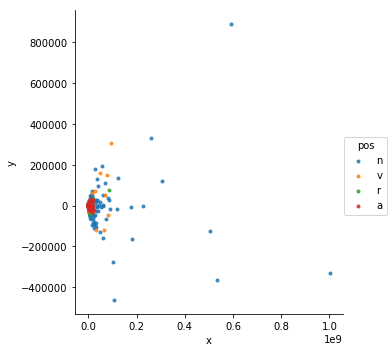

In [45]:
seaborn.lmplot(x='x', y='y', data=svd_reduced_data, fit_reg=False, hue='pos', markers='.')

We can see that this representation generates more outlier points, but it groups together the pos tags. The same graph without the outliers looks like:

(-50000000.0, 150000000.0)

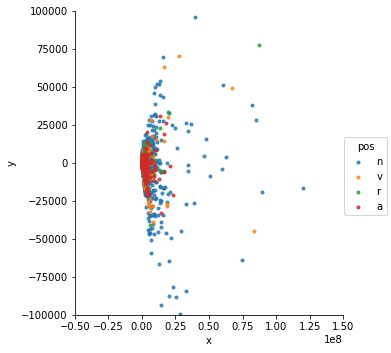

In [59]:
lm = seaborn.lmplot(x='x', y='y', data=svd_reduced_data, fit_reg=False, hue='pos', markers='.', )
lm.axes[0,0].set_ylim(-100000, 100000)
lm.axes[0,0].set_xlim(-0.05e9, 0.15e9)

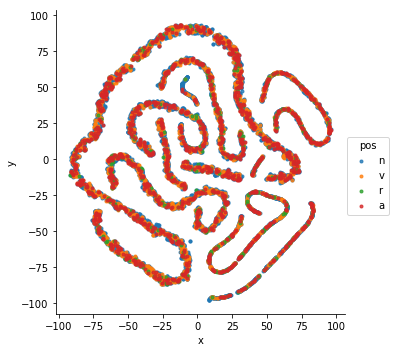

In [61]:
tsne_reduced_data = pandas.DataFrame(
    TSNE(n_components=2, metric='euclidean').fit_transform(result.todense()), columns=['x', 'y'])
tsne_reduced_data['pos'] = [coocurrence_matrix.get_wordnet_pos(word.split('-')[-1]) for word in words]
tsne_reduced_data['word'] = words

seaborn.lmplot(x='x', y='y', data=tsne_reduced_data, fit_reg=False, hue='pos', markers='.')

## Clustering

In [65]:
mbk = KMeans(init='k-means++', n_clusters=10, precompute_distances=True)
kmeans_clusters = mbk.fit_predict(result)

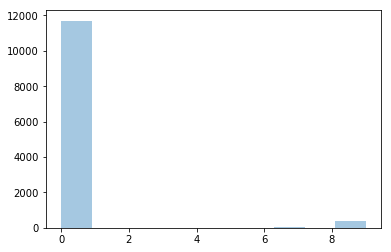

In [81]:
seaborn.distplot(kmeans_clusters, bins=10, kde=False)

In [69]:
indices_to_words = {k: v for (k,v) in enumerate(words)}

In [72]:
get_centroids(mbk, result, indices_to_words)

['attempt-VB',
 ',-,',
 'had-VBD',
 'the-DT',
 'and-CC',
 'no-DT',
 'that-IN',
 'that-WDT',
 '.-.',
 'issue-NN']

In [84]:
spectral= SpectralClustering(n_clusters=10)
spectral_clusters = spectral.fit_predict(result)

/home/mteruel/anaconda2/envs/env35/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


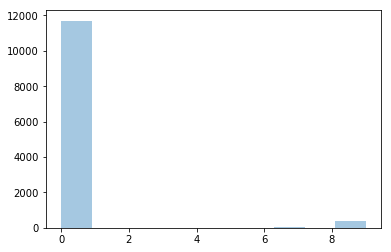

In [87]:
seaborn.distplot(kmeans_clusters, bins=10, kde=False)

(-50000000.0, 150000000.0)

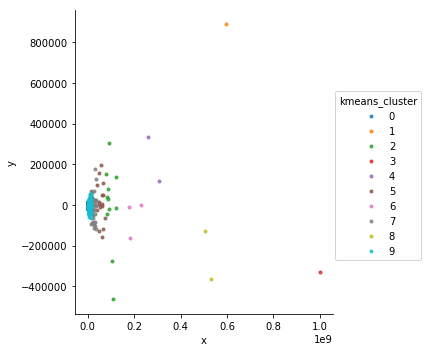

In [74]:
svd_reduced_data['kmeans_cluster'] = kmeans_clusters
seaborn.lmplot(x='x', y='y', data=svd_reduced_data, fit_reg=False, hue='kmeans_cluster', markers='.')
lm.axes[0,0].set_ylim(-100000, 100000)
lm.axes[0,0].set_xlim(-0.05e9, 0.15e9)

(-50000000.0, 150000000.0)

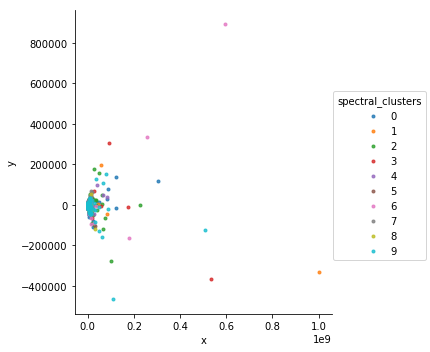

In [85]:
svd_reduced_data['spectral_clusters'] = spectral_clusters
seaborn.lmplot(x='x', y='y', data=svd_reduced_data, fit_reg=False, hue='spectral_clusters', markers='.')
lm.axes[0,0].set_ylim(-100000, 100000)
lm.axes[0,0].set_xlim(-0.05e9, 0.15e9)

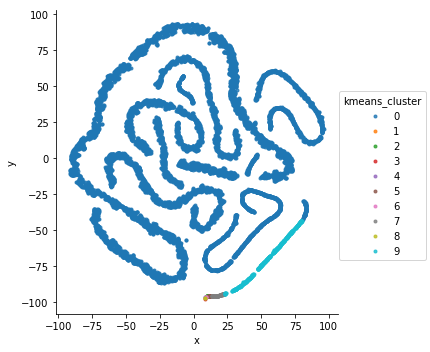

In [75]:
tsne_reduced_data['kmeans_cluster'] = kmeans_clusters
seaborn.lmplot(x='x', y='y', data=tsne_reduced_data, fit_reg=False, hue='kmeans_cluster', markers='.')

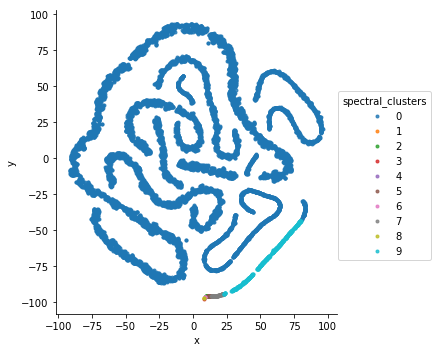

In [86]:
tsne_reduced_data['spectral_clusters'] = kmeans_clusters
seaborn.lmplot(x='x', y='y', data=tsne_reduced_data, fit_reg=False, hue='spectral_clusters', markers='.')

## References

Stab, Christian & Gurevych, Iryna. (2016). Parsing Argumentation Structures in Persuasive Essays. Computational Linguistics. 43. . 10.1162/COLI_a_00295. 

L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research

T. Calinski and J. Harabasz, 1974. “A dendrite method for cluster analysis”. Communications in Statistics